# ANPR(Automatic Number Plate Recognition) 개선

#### 라이브러리

In [4]:
# pytorch
import torch

# OpenCV, OCR
import cv2
import pytesseract
from skimage.transform import resize

# Visualizatipn
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font', family='malgun gothic')
plt.rc('axes', unicode_minus=False)

# Data Handling
import numpy as np
import pandas as pd
from time import time

#### Yolo v5 로드

In [3]:
# Load Yolov5
model = torch.hub.load('ultralytics/yolov5', 'yolov5m')  #yolov5s, yolov5m, yolov5l, yolov5x, custom
model.classes = [2, 7] # car, truck

Using cache found in C:\Users\82105/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2021-8-28 torch 1.9.0+cpu CPU

Fusing layers... 
Model Summary: 308 layers, 21356877 parameters, 0 gradients
Adding AutoShape... 


#### 보안1 : 자동차 번호판 글자 인식

In [5]:
### Get Box Info
def get_croped_image(results, image_show=True):
    boxes = results.pandas().xyxy[0]  # frame1 predictions (pandas)
    x1 = int(boxes.xmin[0])
    x2 = int(boxes.xmax[0])
    y1 = int(boxes.ymin[0])
    y2 = int(boxes.ymax[0])

    # Get Croped Image
    car_image = cv2.resize(frame[y1:y2, x1:x2], dsize=(600, 300))
    if image_show:
        plt.figure(figsize=(7, 5))
        plt.imshow(car_image)
        plt.title('원본 Croped & Resized')
        plt.show()
    return car_image

### Convert Image to Grayscale
def img_to_gray(image, image_show=True):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if image_show:
        plt.figure(figsize=(7,5))
        plt.imshow(gray, cmap='gray')
        plt.title('흑백화')
    return gray

### Adaptive Thresholding
# Thresholding을 해주기 전에 가우시안 블러를 해주는 것이 번호판을 더 잘 찾게 만들어 준다
# 가우시안 블러는 노이즈를 없애주는 작업
def img_gaussianBlur(image, image_show=True):
    img_blurred = cv2.GaussianBlur(image, ksize=(5, 5), sigmaX=0)
    # Thresholding : 지정한 threshold 값을 기준으로 이보다 낮은 값은 0, 높은 값은 255로 변환
    # 흑과 백으로만 사진을 구성하는 것 -> 이후 단계에서 Contours를 찾으려면 검은색 배경에 흰색 바탕이어야 하기 때문
    img_blur_thresh = cv2.adaptiveThreshold(
        img_blurred,
        maxValue=255.0,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY_INV,
        blockSize=19,
        C=9
    )
    if image_show:
        plt.figure(figsize=(7, 5))
        plt.imshow(img_blur_thresh, cmap='gray')
        plt.title('Blur and Threshold')    
    """ 이후에 번호판 기울기 조정에 사용되는 사진은 thresholding이 되지 않은 img_thresh임"""
    """ 이게 더 번호판 인식이 잘 됨"""
    img_thresh = cv2.adaptiveThreshold(
        image,
        maxValue=255.0,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY_INV,
        blockSize=19,
        C=9
    )
    
    return img_blur_thresh, img_thresh

### Find Contours
# Contours란 동일한 색 또는 동일한 강도를 가지고 있는 영역의 경계선을 연결한 선임
# findContours()는 이런 Contours를 찾는 opencv 메소드임 : 검은색 바탕에서 흰색 대상을 찾음(가우시안 블러를 적용해준 이유)
# 출력값으로 contours, hierachy를 받는데 hierachy는 쓸일이 없어 _로 받음
def find_contours(image, image_show=True):
    _, contours, _ = cv2.findContours(
        image,
        mode=cv2.RETR_LIST,
        method=cv2.CHAIN_APPROX_SIMPLE
    )
    contours_result = np.zeros((height, width, channel), dtype=np.uint8)
    cv2.drawContours(contours_result, contours=contours, contourIdx=-1, color=(255,255,255))
    if image_show:
        plt.figure(figsize=(7, 5))
        plt.imshow(contours_result)
        plt.title('Find Contours')
    return contours

### Prepare Data
# 찾은 Contours들의 좌표를 이용해 사각형 형태로 그려본다.
# 동시에 딕셔너리를 하나 만들어 contours들의 정보를 저장한다.
def draw_contours(contours, image_show=True):
    rectangle_result = np.zeros((height, width, channel), dtype=np.uint8)
    contours_dict = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(rectangle_result, pt1=(x,y), pt2=(x+w, y+h), color=(255,255,255), thickness=2)

        contours_dict.append({
            'contour': contour,
            'x': x,
            'y': y,
            'w': w,
            'h': h,
            'cx': x + (w / 2),
            'cy': y + (h / 2)
        })
    if image_show:
        plt.figure(figsize=(7,5))
        plt.imshow(rectangle_result, cmap='gray')
        plt.title('Draw Rectangle')  
    return contours_dict

### Select Candidates by Char Size
# 번호판 글자인 것 같은 박스들을 추려해기 위해서 w(너비)/h(높이)의 비율을 이용한다
# 아래 코드에서는 최소 비율을 0.25와 최대 비율을 1.0으로 설정한 후 기준에 맞는 박스들만 따로 저장하였다
def pickout_plate_contours01(contours_dict, image_show=True):

    possible_contours = []

    cnt = 0 # cnt로 새로운 idx를 부여
    for d in contours_dict:
        area = d['w'] * d['h']
        ratio = d['w'] / d['h']

        if area > MIN_AREA \
        and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
        and MIN_RATIO < ratio < MAX_RATIO:
            d['idx'] = cnt
            cnt += 1
            possible_contours.append(d)

    tempPlate_result = np.zeros((height, width, channel), dtype = np.uint8)
    for d in possible_contours:
        cv2.rectangle(tempPlate_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)
    if image_show:
        plt.figure(figsize=(7, 5))
        plt.imshow(tempPlate_result, cmap='gray')
        plt.title('번호판이라 추정되는 박스1')
    return possible_contours 

### Select Candidates by Arrangement of Contours
# 남은 박스들 중에 확실하게 번호판을 찾기 위해 기준을 강화한다.
# 1. 번호판 글자 박스들은 width와 height의 비율이 모두 동일하거나 비슷하다
# 2. 번호판 글자 박스들 사이의 간격은 일정하다
# 3. 최소 3개 이상의 Contours가 인접해 있어야 한다. (대한민국 기준)
def pickout_plate_contours02(possible_contours, image_show=True):

    MAX_DIAG_MULTIPLYER = 5   # 측정 박스 대각선 길이의 5배 안에 있어야 함
    MAX_ANGLE_DIFF = 12.0     # 박스 간 중심을 이었을 때 직각삼각형이 그려지는 때 그때의 최대 기울기 theta 값
    MAX_AREA_DIFF = 0.5       # 면적의 차이
    MAX_WIDTH_DIFF = 0.8      # 너비의 차이
    MAX_HEIGHT_DIFF = 0.2     # 높이의 차이
    MIN_N_MATCHED = 3         # 위의 조건을 만족하는 경우가 3개 이상이어야 함

    def find_chars(contour_list): # 재귀 함수를 이용해 찾기 때문에 함수로 저장
        matched_result_idx = []

        for d1 in contour_list:
            matched_contours_idx = []
            for d2 in contour_list:
                if d1['idx'] == d2['idx']:
                    continue

                dx = abs(d1['cx'] - d2['cx'])
                dy = abs(d1['cy'] - d2['cy'])

                diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

                distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
                if dx == 0:
                    angle_diff = 90
                else:
                    angle_diff = np.degrees(np.arctan(dy / dx))
                area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
                width_diff = abs(d1['w'] - d2['w']) / d1['w']
                height_diff = abs(d1['h'] - d2['h']) / d1['h']

                if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
                and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
                and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                    matched_contours_idx.append(d2['idx'])

            matched_contours_idx.append(d1['idx'])

            if len(matched_contours_idx) < MIN_N_MATCHED:
                continue

            matched_result_idx.append(matched_contours_idx)

            unmatched_contour_idx = []
            for d4 in contour_list:
                if d4['idx'] not in matched_contours_idx:
                    unmatched_contour_idx.append(d4['idx'])

            unmatched_contour = np.take(possible_contours, unmatched_contour_idx)

            recursive_contour_list = find_chars(unmatched_contour)

            for idx in recursive_contour_list:
                matched_result_idx.append(idx)

            break

        return matched_result_idx

    result_idx = find_chars(possible_contours)

    matched_result = []
    for idx_list in result_idx:
        matched_result.append(np.take(possible_contours, idx_list))

    tempPlate_result2 = np.zeros((height, width, channel), dtype=np.uint8)

    for r in matched_result:
        for d in r:
            cv2.rectangle(tempPlate_result2, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255,255,255), thickness=2)
    if image_show:
        plt.figure(figsize=(7, 5))
        plt.imshow(tempPlate_result2, cmap='gray')
        plt.title('번호판이라 추정되는 박스2')
        plt.show()
        
    return matched_result

### Rotate Plate Images
# 자동차가 정방향에서 찍힌 경우면 번호판이 가지런하지만 대부분의 경우 번호판이 기울어져서 찍힘
# pytesseract를 이용하여 번호판을 인식하기 위해 번호판 부분을 정방향으로 만들어 줄 필요가 있음
# 따라서 Affine Transform을 적용하고 해당 부분만 Crop하여 출력함
def plate_affine_and_crop(matched_result, img_thresh, image_show=True):

    PLATE_WIDTH_PADDING = 1.3
    PLATE_HEIGHT_PADDING = 1.5
    MIN_PLATE_RATIO = 3
    MAX_PLATE_RATIO = 10

    plate_imgs = []
    plate_infos = []

    for i, matched_chars in enumerate(matched_result):
        sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])

        plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
        plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2

        plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING

        sum_height = 0
        for d in sorted_chars:
            sum_height += d['h']

        plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)

        triangle_height = sorted_chars[-1]['cy'] - sorted_chars[0]['cy']
        triangle_hypotenus = np.linalg.norm(
            np.array([sorted_chars[0]['cx'], sorted_chars[0]['cy']]) - 
            np.array([sorted_chars[-1]['cx'], sorted_chars[-1]['cy']])
        )

        angle = np.degrees(np.arcsin(triangle_height / triangle_hypotenus))

        rotation_matrix = cv2.getRotationMatrix2D(center=(plate_cx, plate_cy), angle=angle, scale=1.0)

        img_rotated = cv2.warpAffine(img_thresh, M=rotation_matrix, dsize=(width, height))

        img_cropped = cv2.getRectSubPix(
            img_rotated, 
            patchSize=(int(plate_width), int(plate_height)), 
            center=(int(plate_cx), int(plate_cy))
        )

        if img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO or img_cropped.shape[1] / img_cropped.shape[0] < MIN_PLATE_RATIO > MAX_PLATE_RATIO:
            continue

        plate_imgs.append(img_cropped)
        plate_infos.append({
            'x': int(plate_cx - plate_width / 2),
            'y': int(plate_cy - plate_height / 2),
            'w': int(plate_width),
            'h': int(plate_height)
        })
        if image_show:
            plt.figure(figsize=(7, 5)) # 원래 plt.subplot(len(matched_result), 1, i+1)
                                       # 원래 i에 따라서 몇개의 후보군이 출력되게 된다. 번호판 사진이 여러개일 수 있음
            plt.imshow(img_cropped, cmap='gray')
            plt.title('기울기 변환한 번호판')    
    return plate_imgs

### 번호판 전처리, OCR
def plate_preprocessing_OCR(plate_imgs, image_show=True):

    longest_idx, longest_text = -1, 0
    plate_chars = []

    for i, plate_img in enumerate(plate_imgs):
        plate_img = cv2.resize(plate_img, dsize=(0, 0), fx=1.6, fy=1.6)
        _, plate_img = cv2.threshold(plate_img, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)

        # find contours again (same as above)
        """위에 plate_img에 또 다른 후보군을 넣기 위한 작업 """
        _, contours, _ = cv2.findContours(plate_img, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)

        plate_min_x, plate_min_y = plate_img.shape[1], plate_img.shape[0]
        plate_max_x, plate_max_y = 0, 0

        for contour in contours:
            x, y, w, h = cv2.boundingRect(contour)

            area = w * h
            ratio = w / h

            if area > MIN_AREA \
            and w > MIN_WIDTH and h > MIN_HEIGHT \
            and MIN_RATIO < ratio < MAX_RATIO:
                if x < plate_min_x:
                    plate_min_x = x
                if y < plate_min_y:
                    plate_min_y = y
                if x + w > plate_max_x:
                    plate_max_x = x + w
                if y + h > plate_max_y:
                    plate_max_y = y + h


        img_result = plate_img[plate_min_y:plate_max_y, plate_min_x:plate_max_x]
        
### Find Chars
# 추린 후보군을 이용하여 글자를 찾는다      
        img_result = cv2.GaussianBlur(img_result, ksize=(3, 3), sigmaX=0)
        _, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))

#print(pytesseract.image_to_string(img_cropped,
#    lang='cuskor',
#    config='-c tessedit_char_whitelist=0123456789가나다라마바사아자거너더러머버서어저고노도로모보소오조구누두루무부수우주하허호배 --psm 7 --oem 3'))
        
        pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'   
    #    pytesseract.pytesseract.tesseract_cmd = 'D:/tesseract/tesseract.exe'
        chars = pytesseract.image_to_string(img_result, lang='kor', config='--psm 7 --oem 0')
#        chars = pytesseract.image_to_string(img_result, lang='kor', config='-c tessedit_char_whitelist=0123456789가나다라마바사아자차거너더러머버서어저고노도로모보소오조구누두루무부수우주하허호배 --psm 7 --oem 3')
        """ 자동차 번호판은 result_chars에 저장됨 """
        result_chars = ''
        has_digit = False
        for c in chars:
            if ord('가') <= ord(c) <= ord('힣') or c.isdigit():
                if c.isdigit():
                    has_digit = True
                result_chars += c

        #print(result_chars)
        plate_chars.append(result_chars)

        if has_digit and len(result_chars) > longest_text:
            longest_idx = i

        if image_show:
            plt.figure(figsize=(7, 5)) # 원래 plt.subplot(len(plate_imgs), 1, i+1)
            plt.imshow(img_result, cmap='gray')
            plt.title('Blur and Threshold Plate')
    return plate_chars

#### 보안 1 모든 과정 함수화

In [6]:
def ANPR_process(car_image):
    gray_img = img_to_gray(car_image, image_show=False)                              # 흑백화
    img_blur_thresh, img_thresh = img_gaussianBlur(gray_img, image_show=False)       # 전처리 가우시안블러
    contours = find_contours(img_blur_thresh, image_show=False)                      # Contours 찾음
    contours_dict = draw_contours(contours, image_show=False)                        # 찾은 Contours를 박스로 그림
    possible_contours = pickout_plate_contours01(contours_dict, image_show=False)    # 번호판추정 예비 박스
    matched_result = pickout_plate_contours02(possible_contours, image_show=False)   # 번호판추정 최종 박스
    plate_imgs = plate_affine_and_crop(matched_result, img_thresh, image_show=False)             # 번호판 기울기 조정, 추출
    plate_chars = plate_preprocessing_OCR(plate_imgs, image_show=False)              # 번호판 전처리, 글자추출
    return plate_chars

#### 보안 2-1 : 이미지 매칭(평균 해시 매칭)  

In [120]:
# 이미지를 16x16 크기의 평균 해쉬로 변환
def img2hash(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#    gray = cv2.resize(gray, (600, 300)) # 이미지 croped & resize된 사진을 받음
    avg = gray.mean()
    bi = 1 * (gray > avg)
    return bi

# 해밍거리 측정 함수
def hamming_distance(a, b):
    a = a.reshape(1,-1)
    b = b.reshape(1,-1)
    # 같은 자리의 값이 서로 다른 것들의 합
    distance = (a !=b).sum()
    return distance

def image_match(image, stored_hash):
    # 들어온 차량의 이미지
    income_car_image = image    
    # 차 영상의 해쉬 구하기
    query_hash = img2hash(income_car_image)
    
    # 해당 차량의 저장된 해쉬 불러오기
    stored_hash = stored_hash
    
    # 해밍 거리 산출
    flag = 0
    hamming_dst = hamming_distance(query_hash, stored_hash)
    if hamming_dst/256 < matching_criterion: flag=1; print('이미지매칭: 동일 차량입니다.')
    else: print('동일하지 않은 차량입니다.')
    print(hamming_dst/256)
        
    return income_car_image, flag

#### 보안 2-2 : 특징 검출기와 평가 지표(ORB와 knnMatch)

In [8]:
# 서술자 추출 함수
def get_desc(img):
    img = img
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kp, desc = detector.detectAndCompute(gray, None)
    return kp, desc

In [135]:
# ORB로 서술자 추출 
detector = cv2.ORB_create()

# BF-Hamming 생성
matcher = cv2.BFMatcher(cv2.NORM_HAMMING2)

def ORB_knnMatch(income_car_image, flag, stored_kp, stored_desc):
    # 각 영상에 대해 키 포인트와 서술자 추출 
    compare_kp, compare_desc = get_desc(income_car_image)
    # knnMatch, k=2
    matches = matcher.knnMatch(compare_desc, stored_desc, 2)

    # 첫번재 이웃의 거리가 두 번째 이웃 거리의 75% 이내인 것만 추출---⑤
    ratio = 0.75; desc_flag = 0
    good_matches = [first for first,second in matches \
                        if first.distance < second.distance * ratio]
    if len(good_matches) < desc_criterion: desc_flag = 1; print('특징점 비교: 동일 차량입니다.')
    else: print('동일하지 않은 차량입니다')
    print('matches:%d/%d' %(len(good_matches),len(matches)))
    return desc_flag
    #print('matches:%d/%d' %(len(good_matches),len(matches)))

    # 좋은 매칭만 그리기
    #res = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, \
     #                   flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
    # 결과 출력
    #plt.figure(figsize=(15, 10))
    #plt.imshow(res)
    #plt.show()

#### Needs

In [121]:
# 차량 진입 조건문 파라미터
confidence = 0.80
car_size = 80000

# 보안 1: 번호판 추출 기준 파라미터
MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT= 2, 8 # 원래 2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.0 

# 보안 2: 이미지 매칭 기준 파라미터, 특징점 매칭 기준 파라미터
matching_criterion = 215
desc_criterion = 70

# 차량 진입시 최대 4장의 사진을 찍도록 함 (일단은, 나중에 없앨수도 있음)
frame_num = 1 

In [218]:
# 데이터베이스 데이터
def imread(filename, flags=cv2.IMREAD_COLOR, dtype=np.uint8):
    try:
        n = np.fromfile(filename, dtype) 
        img = cv2.imdecode(n, flags) 
        return img 
    except Exception as e: 
        print(e) 
        return None
    
greencar01 = imread('./car_image/그린카진입01.jpg')
greencar02 = imread('./car_image/그린카진입02.jpg')
socar01 = imread('./car_image/쏘카진입01.jpg')
socar02 = imread('./car_image/쏘카진입02.jpg')

greencar01_hash = img2hash(greencar01)
greencar02_hash = img2hash(greencar02)
socar01_hash = img2hash(socar01)
socar02_hash = img2hash(socar02)

greencar01_kp, greencar01_desc = get_desc(greencar01)
greencar02_kp, greencar02_desc = get_desc(greencar02)
socar01_kp, socar01_desc = get_desc(socar01)
socar02_kp, socar02_desc = get_desc(socar02)

# 데이터베이스
database = pd.DataFrame({
    '번호판' : ['26차2861', '12차1234', '23차2345', '37허0897'],
    'StoredHash' : [greencar01_hash, greencar02_hash, greencar01_hash, greencar02_hash],
    'KeyPoints' : [greencar01_kp, greencar02_kp, greencar01_kp, greencar02_kp],
    'Descriptors' : [greencar01_desc, greencar02_desc, greencar01_desc, greencar02_desc],
    '내부존재여부' : [0, 0, 0, 0]
})
database

,번호판,StoredHash,KeyPoints,Descriptors,내부존재여부
0,26차2861,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[<KeyPoint 00000295995003C0>, <KeyPoint 000002...","[[91, 223, 123, 202, 183, 252, 255, 247, 45, 7...",0
1,12차1234,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[<KeyPoint 0000029599500090>, <KeyPoint 000002...","[[191, 30, 239, 254, 46, 35, 239, 89, 215, 234...",0
2,23차2345,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[<KeyPoint 00000295995003C0>, <KeyPoint 000002...","[[91, 223, 123, 202, 183, 252, 255, 247, 45, 7...",0
3,37허0897,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[<KeyPoint 0000029599500090>, <KeyPoint 000002...","[[191, 30, 239, 254, 46, 35, 239, 89, 215, 234...",0


<font color=blue>
    
# Main

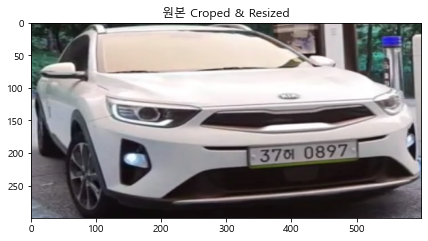

이미지 매칭을 시작합니다
이미지매칭: 동일 차량입니다.
211.359375
특징점을 매칭을 시작합니다
특징점 비교: 동일 차량입니다.
matches:49/496
내부에 차량이 존재하는지 파악중입니다
차량 통과


In [216]:
# 1. 카메라 작동
frame_num = 1 
cap = cv2.VideoCapture(f'./car_image/그린카성원폰01.mp4')
while cap.isOpened():
    if frame_num == 5: break # break문 : 4장의 사진을 찍은 후 종료
    hasFrame, frame = cap.read()
    if not hasFrame:
        break

    # 2. 카메라영상을 받은 Yolo v5가 Object Dectection 작동
    results = model(frame, size=328)

    # 3. 3가지의 조건문 통과시 보안 알고리즘 작동
    if len(results.pred[0]) == 0:                 # 1. 디텍션이 안되면 pred정보가 없어 len이 0을 유지
        continue
    if results.pred[0][0][4].item() < confidence: # 2. 디텍션이 되었지만 confidence > 0.80 이상일때까지 작동 x
        continue
    if (results.pandas().xywh[0].width * results.pandas().xywh[0].height)[0] < car_size:
        continue                                 # 3. 차량이 진입함에 따라 car_size보다 커졌을 때 작동
    frame_num += 1

    # Crop&Resize detection image 
    car_image = get_croped_image(results, image_show=True)

    # Get Image Size
    height, width, channel = car_image.shape

    # 4-1. 보안1 : 번호판 추출
    plate_chars = ANPR_process(car_image)
    # 4-2. 데이터베이스 번호판 비교
    if plate_chars[0] in database['번호판'].tolist():
        
        # 5-1. 보안 2-1 : 이미지 매칭
        print('이미지 매칭을 시작합니다')
        stored_hash = database.query('번호판 == @plate_chars[0]')['StoredHash'].values[0] # 번호판에 부합하는 hash 정보 불러옴
        income_car_image, flag = image_match(car_image, stored_hash)
        # 5-2. flag가 1일 경우 이미지 매칭 통과
        if flag == 1:
            
            # 6-1. 보안 2-2 : 특징점 매칭
            print('특징점을 매칭을 시작합니다')
            stored_kp = database.query('번호판 == @plate_chars[0]')['KeyPoints'].values[0]
            stored_desc = database.query('번호판 == @plate_chars[0]')['Descriptors'].values[0]
            desc_flag = ORB_knnMatch(income_car_image, flag, stored_kp, stored_desc)
            # 6-2. desc_flag가 1일 경우 특징점 매칭 통과
            if desc_flag == 1:
                
                # 7. 내부에 차량 존재여부 파악
                print('내부에 차량이 존재하는지 파악중입니다')
                if database.query('번호판 == @plate_chars[0]')['내부존재여부'].values[0] == 0:
                    print('차량 통과')
                    db_car_idx = database.query('번호판 == @plate_chars[0]').index[0]
                    database.loc[db_car_idx,'내부존재여부'] = 1 # 차량 진입 상태를 바꿈
                else:
                    print('내부에 이미 차량이 존재합니다. 경비를 호출하십시오.')
                
            else:
                print('특징점 매칭을 통과하지 못했습니다')
            
        else:
            print('이미지 매칭을 통과하지 못했습니다.')
        
    else:
        print('등록되지 않은 차량입니다.')
    break
#print(f'{video_nm}: ', plate_number_lst)
#print(plate_number_lst)


In [217]:
database

,번호판,StoredHash,KeyPoints,Descriptors,내부존재여부
0,26차2861,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[<KeyPoint 00000295AC0F71B0>, <KeyPoint 000002...","[[91, 223, 123, 202, 183, 252, 255, 247, 45, 7...",0
1,12차1234,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[<KeyPoint 00000295AC0F76C0>, <KeyPoint 000002...","[[191, 30, 239, 254, 46, 35, 239, 89, 215, 234...",0
2,23차2345,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[<KeyPoint 00000295AC0F71B0>, <KeyPoint 000002...","[[91, 223, 123, 202, 183, 252, 255, 247, 45, 7...",0
3,37허0897,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[<KeyPoint 00000295AC0F76C0>, <KeyPoint 000002...","[[191, 30, 239, 254, 46, 35, 239, 89, 215, 234...",1
